In [6]:
import warnings                                  # `do not disturbe` mode
warnings.filterwarnings('ignore')
from datetime import datetime
print(datetime.now())
import os
print(os.getcwd())

#====
import numpy as np
import pandas as pd
import pandasql
#import sqlalchemy
import pymongo


import matplotlib.pyplot as plt                  # plots
import seaborn as sns                            # more plots
from dateutil.relativedelta import relativedelta # working with dates with style
from scipy.optimize import minimize              # for function minimization

import statsmodels.formula.api as smf            # statistics and econometrics
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

from itertools import product                    # some useful functions
from tqdm import tqdm_notebook



%matplotlib inline


2021-03-11 02:43:00.469490
/Volumes/GoogleDrive/My Drive/01_Mac2021/05_Work/00_Pruebas técnicas/01_software_engenieer/00_agranimo


ModuleNotFoundError: No module named 'statsmodels'

In [2]:

df = pd.read_csv("docs/Event.csv", 
                 #index_col= ["payload.TMS"],
                 parse_dates = ["payload.TMS"], 
                 dtype = {
                         #"payload.TMS": 'datetime64[ns]'
                         }
                )

df.info()
df = df.sort_values(by="payload.TMS")
print(datetime.now())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 459556 entries, 0 to 459555
Data columns (total 34 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   _id             459556 non-null  object 
 1   createdAt       459556 non-null  object 
 2   packet.cmd      459556 non-null  object 
 3   packet.dup      459556 non-null  bool   
 4   packet.length   459556 non-null  int64  
 5   packet.payload  459556 non-null  object 
 6   packet.qos      459556 non-null  int64  
 7   packet.retain   459556 non-null  bool   
 8   packet.topic    459556 non-null  object 
 9   payload.BFMW    340043 non-null  float64
 10  payload.BSID    340043 non-null  object 
 11  payload.DID     459556 non-null  object 
 12  payload.FMW     452372 non-null  float64
 13  payload.TMS     452372 non-null  object 
 14  payload.bvol    452372 non-null  float64
 15  payload.hum1    123892 non-null  float64
 16  payload.lwet    35617 non-null   float64
 17  payload.pr

##### Let's check the columns in our database

In [3]:
print(datetime.now())

#Columns refered to payload
columns_payload = [col for col in df.columns if col.startswith("payload")]

#Columns refered to packet 
columns_packet = [col for col in df.columns if col.startswith("packet")]

columns = [#"_id",
           #"processed",
           "payload.DID",
           "payload.hum1",
           "payload.TMS",
           "payload.prec",
           "payload.solr",
           "payload.tem1",
          ]
base = df[columns]

rename_columns = { 
                   #"_id":"id",
                   #"processed":"processed",
                   "payload.DID":"payload_DID",
                   "payload.hum1":"payload_hum1",
                   "payload.TMS":"payload_TMS",
                   "payload.prec":"payload_prec",
                   "payload.solr":"payload_solr",
                   "payload.tem1":"payload_tem1",
                    }
base = base.rename(columns = rename_columns)

base = base.dropna(subset = ["payload_TMS"])
base["payload_TMS"] = pd.to_datetime(base.payload_TMS, unit='s')
base = base.sort_values(by="payload_TMS")
base.info()


2021-03-10 23:38:16.013854
<class 'pandas.core.frame.DataFrame'>
Int64Index: 452372 entries, 351921 to 459553
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   payload_DID   452372 non-null  object        
 1   payload_hum1  123892 non-null  float64       
 2   payload_TMS   452372 non-null  datetime64[ns]
 3   payload_prec  8311 non-null    float64       
 4   payload_solr  123892 non-null  float64       
 5   payload_tem1  123892 non-null  float64       
dtypes: datetime64[ns](1), float64(4), object(1)
memory usage: 24.2+ MB


In [4]:
print(datetime.now())
print(base.payload_TMS.head())
base['payload_TMS_index'] = base['payload_TMS']
base.set_index('payload_TMS_index', inplace=True) #setting payload_TMS as index of the dataframe
#base = base.tz_localize("UTC") #converting date times with timezone information
#When we do localize we notice that are in different time-zone. So, we better do 
base = base.tz_localize("Europe/Berlin", nonexistent = 'shift_forward')

base.info()
base.head()

2021-03-10 23:38:16.674340
351921   2000-01-01 00:00:02
402964   2000-01-01 00:00:02
247571   2000-01-01 00:00:02
274498   2000-01-01 00:00:02
274730   2000-01-01 00:00:02
Name: payload_TMS, dtype: datetime64[ns]
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 452372 entries, 2000-01-01 00:00:02+01:00 to 2021-03-05 12:16:36+01:00
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   payload_DID   452372 non-null  object        
 1   payload_hum1  123892 non-null  float64       
 2   payload_TMS   452372 non-null  datetime64[ns]
 3   payload_prec  8311 non-null    float64       
 4   payload_solr  123892 non-null  float64       
 5   payload_tem1  123892 non-null  float64       
dtypes: datetime64[ns](1), float64(4), object(1)
memory usage: 24.2+ MB


,payload_DID,payload_hum1,payload_TMS,payload_prec,payload_solr,payload_tem1
payload_TMS_index,,,,,,
2000-01-01 00:00:02+01:00,5_157,NaN,2000-01-01 00:00:02,NaN,NaN,NaN
2000-01-01 00:00:02+01:00,5_156,NaN,2000-01-01 00:00:02,NaN,NaN,NaN
2000-01-01 00:00:02+01:00,5_156,NaN,2000-01-01 00:00:02,NaN,NaN,NaN
2000-01-01 00:00:02+01:00,5_157,NaN,2000-01-01 00:00:02,NaN,NaN,NaN
2000-01-01 00:00:02+01:00,5_150,NaN,2000-01-01 00:00:02,NaN,NaN,NaN


In [5]:
print(pd.Index(base).is_all_dates)
base.head()
base.tail()

False


,payload_DID,payload_hum1,payload_TMS,payload_prec,payload_solr,payload_tem1
payload_TMS_index,,,,,,
2021-03-05 12:15:06+01:00,5_49,NaN,2021-03-05 12:15:06,NaN,NaN,NaN
2021-03-05 12:15:51+01:00,1_125,59.8,2021-03-05 12:15:51,NaN,331.0,6.9
2021-03-05 12:15:51+01:00,1_63,82.2,2021-03-05 12:15:51,NaN,185.0,17.7
2021-03-05 12:16:16+01:00,1_101,77.6,2021-03-05 12:16:16,NaN,160.0,17.2
2021-03-05 12:16:36+01:00,1_51,95.0,2021-03-05 12:16:36,NaN,92.0,16.8


In [6]:
def PlotIndexSet(x_axis, y_axis, df ):
    """
    Plot a column of a dataframe. x_axis is the index.
    x_axis (str)
    y_axis (str)
    """
    plt.figure(figsize=(15, 7))
    plt.plot(df[y_axis])
    title = 'Variable '+ y_axis + ' watched over ' + x_axis +'.'
    plt.title(title)
    plt.grid(True)
    plt.show()
    print(df.head())
    


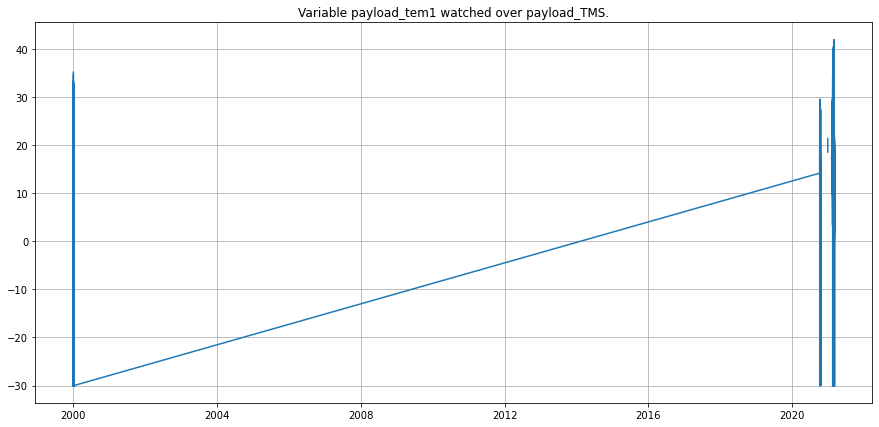

                          payload_DID  payload_hum1         payload_TMS  \
payload_TMS_index                                                         
2000-01-01 00:00:02+01:00       5_157           NaN 2000-01-01 00:00:02   
2000-01-01 00:00:02+01:00       5_156           NaN 2000-01-01 00:00:02   
2000-01-01 00:00:02+01:00       5_156           NaN 2000-01-01 00:00:02   
2000-01-01 00:00:02+01:00       5_157           NaN 2000-01-01 00:00:02   
2000-01-01 00:00:02+01:00       5_150           NaN 2000-01-01 00:00:02   

                           payload_prec  payload_solr  payload_tem1  
payload_TMS_index                                                    
2000-01-01 00:00:02+01:00           NaN           NaN           NaN  
2000-01-01 00:00:02+01:00           NaN           NaN           NaN  
2000-01-01 00:00:02+01:00           NaN           NaN           NaN  
2000-01-01 00:00:02+01:00           NaN           NaN           NaN  
2000-01-01 00:00:02+01:00           NaN           NaN 

In [7]:
PlotIndexSet(df=base, x_axis='payload_TMS', y_axis='payload_tem1')

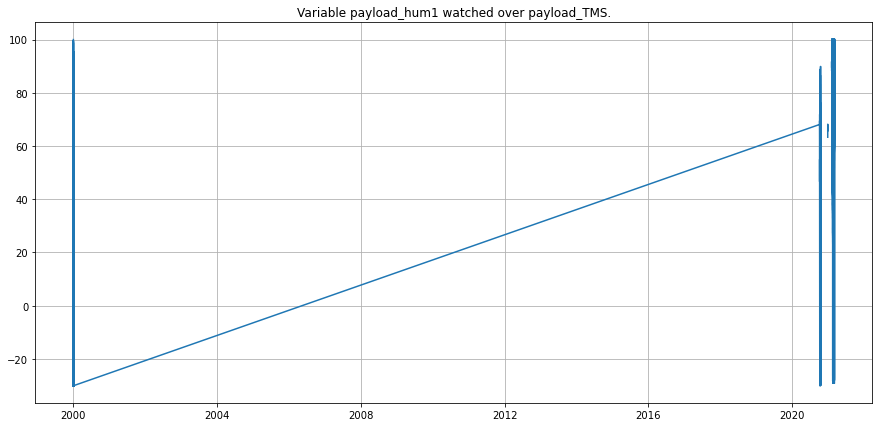

                          payload_DID  payload_hum1         payload_TMS  \
payload_TMS_index                                                         
2000-01-01 00:00:02+01:00       5_157           NaN 2000-01-01 00:00:02   
2000-01-01 00:00:02+01:00       5_156           NaN 2000-01-01 00:00:02   
2000-01-01 00:00:02+01:00       5_156           NaN 2000-01-01 00:00:02   
2000-01-01 00:00:02+01:00       5_157           NaN 2000-01-01 00:00:02   
2000-01-01 00:00:02+01:00       5_150           NaN 2000-01-01 00:00:02   

                           payload_prec  payload_solr  payload_tem1  
payload_TMS_index                                                    
2000-01-01 00:00:02+01:00           NaN           NaN           NaN  
2000-01-01 00:00:02+01:00           NaN           NaN           NaN  
2000-01-01 00:00:02+01:00           NaN           NaN           NaN  
2000-01-01 00:00:02+01:00           NaN           NaN           NaN  
2000-01-01 00:00:02+01:00           NaN           NaN 

In [8]:
PlotIndexSet(df=base, x_axis='payload_TMS', y_axis='payload_hum1')

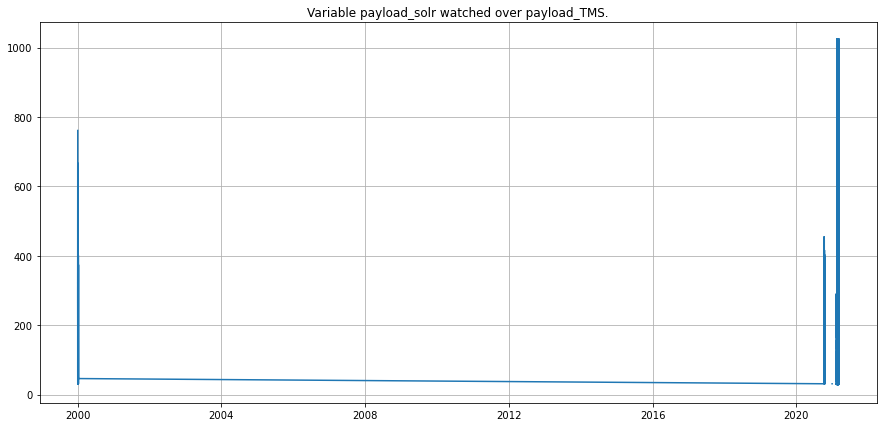

                          payload_DID  payload_hum1         payload_TMS  \
payload_TMS_index                                                         
2000-01-01 00:00:02+01:00       5_157           NaN 2000-01-01 00:00:02   
2000-01-01 00:00:02+01:00       5_156           NaN 2000-01-01 00:00:02   
2000-01-01 00:00:02+01:00       5_156           NaN 2000-01-01 00:00:02   
2000-01-01 00:00:02+01:00       5_157           NaN 2000-01-01 00:00:02   
2000-01-01 00:00:02+01:00       5_150           NaN 2000-01-01 00:00:02   

                           payload_prec  payload_solr  payload_tem1  
payload_TMS_index                                                    
2000-01-01 00:00:02+01:00           NaN           NaN           NaN  
2000-01-01 00:00:02+01:00           NaN           NaN           NaN  
2000-01-01 00:00:02+01:00           NaN           NaN           NaN  
2000-01-01 00:00:02+01:00           NaN           NaN           NaN  
2000-01-01 00:00:02+01:00           NaN           NaN 

In [9]:
PlotIndexSet(df=base, x_axis='payload_TMS', y_axis='payload_solr')

The ploting show that we have to drop all years before 2019

In [15]:
aux = base.reset_index() #Reset the index TMS back to column
aux=base
start_date = '2019-01-01 00:00:02'
end_date = '2042-01-01 00:00:02'
aux.info()
print(aux.loc[start_date:end_date])
base = base.loc[start_date:end_date]

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 452372 entries, 2000-01-01 00:00:02+01:00 to 2021-03-05 12:16:36+01:00
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   payload_DID   452372 non-null  object        
 1   payload_hum1  123892 non-null  float64       
 2   payload_TMS   452372 non-null  datetime64[ns]
 3   payload_prec  8311 non-null    float64       
 4   payload_solr  123892 non-null  float64       
 5   payload_tem1  123892 non-null  float64       
dtypes: datetime64[ns](1), float64(4), object(1)
memory usage: 24.2+ MB
                          payload_DID  payload_hum1         payload_TMS  \
payload_TMS_index                                                         
2020-10-07 16:54:06+02:00        1_34          68.1 2020-10-07 16:54:06   
2020-10-07 17:14:05+02:00        1_34          69.5 2020-10-07 17:14:05   
2020-10-07 17:34:06+02:00        1_34          57.6 2020-10-07 1

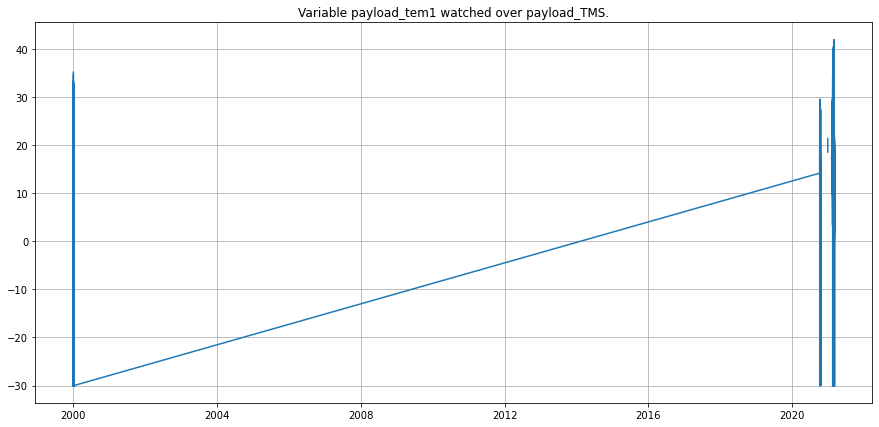

                          payload_DID  payload_hum1         payload_TMS  \
payload_TMS_index                                                         
2000-01-01 00:00:02+01:00       5_157           NaN 2000-01-01 00:00:02   
2000-01-01 00:00:02+01:00       5_156           NaN 2000-01-01 00:00:02   
2000-01-01 00:00:02+01:00       5_156           NaN 2000-01-01 00:00:02   
2000-01-01 00:00:02+01:00       5_157           NaN 2000-01-01 00:00:02   
2000-01-01 00:00:02+01:00       5_150           NaN 2000-01-01 00:00:02   

                           payload_prec  payload_solr  payload_tem1  
payload_TMS_index                                                    
2000-01-01 00:00:02+01:00           NaN           NaN           NaN  
2000-01-01 00:00:02+01:00           NaN           NaN           NaN  
2000-01-01 00:00:02+01:00           NaN           NaN           NaN  
2000-01-01 00:00:02+01:00           NaN           NaN           NaN  
2000-01-01 00:00:02+01:00           NaN           NaN 

In [11]:
PlotIndexSet(df=base, x_axis='payload_TMS', y_axis='payload_tem1')

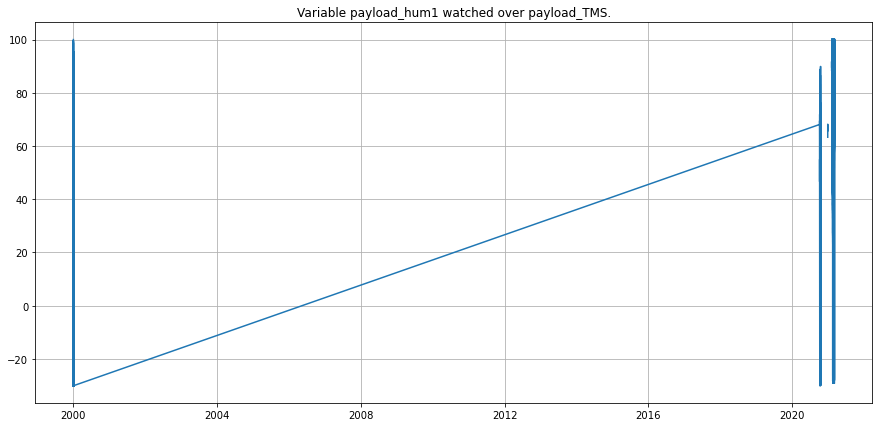

                          payload_DID  payload_hum1         payload_TMS  \
payload_TMS_index                                                         
2000-01-01 00:00:02+01:00       5_157           NaN 2000-01-01 00:00:02   
2000-01-01 00:00:02+01:00       5_156           NaN 2000-01-01 00:00:02   
2000-01-01 00:00:02+01:00       5_156           NaN 2000-01-01 00:00:02   
2000-01-01 00:00:02+01:00       5_157           NaN 2000-01-01 00:00:02   
2000-01-01 00:00:02+01:00       5_150           NaN 2000-01-01 00:00:02   

                           payload_prec  payload_solr  payload_tem1  
payload_TMS_index                                                    
2000-01-01 00:00:02+01:00           NaN           NaN           NaN  
2000-01-01 00:00:02+01:00           NaN           NaN           NaN  
2000-01-01 00:00:02+01:00           NaN           NaN           NaN  
2000-01-01 00:00:02+01:00           NaN           NaN           NaN  
2000-01-01 00:00:02+01:00           NaN           NaN 

In [12]:
PlotIndexSet(df=base, x_axis='payload_TMS', y_axis='payload_hum1')

In [ ]:
PlotIndexSet(df=base, x_axis='payload_TMS', y_axis='payload_solr')

Next step is to set the frequency for one hour. We want to see what to do with the data there. 

In [16]:
aux['payload_TMS_date'] = aux['payload_TMS'].apply(lambda row: row.date())
#aux['TMS_date'].head()
aux['payload_TMS_hour'] = aux['payload_TMS'].apply(lambda row: row.time().hour)
aux['payload_TMS_hour'].head()

payload_TMS_index
2000-01-01 00:00:02+01:00    0
2000-01-01 00:00:02+01:00    0
2000-01-01 00:00:02+01:00    0
2000-01-01 00:00:02+01:00    0
2000-01-01 00:00:02+01:00    0
Name: payload_TMS_hour, dtype: int64

In [17]:
aux.head()
#Agruparemos por DID -> Date -> hour


,payload_DID,payload_hum1,payload_TMS,payload_prec,payload_solr,payload_tem1,payload_TMS_date,payload_TMS_hour
payload_TMS_index,,,,,,,,
2000-01-01 00:00:02+01:00,5_157,NaN,2000-01-01 00:00:02,NaN,NaN,NaN,2000-01-01,0
2000-01-01 00:00:02+01:00,5_156,NaN,2000-01-01 00:00:02,NaN,NaN,NaN,2000-01-01,0
2000-01-01 00:00:02+01:00,5_156,NaN,2000-01-01 00:00:02,NaN,NaN,NaN,2000-01-01,0
2000-01-01 00:00:02+01:00,5_157,NaN,2000-01-01 00:00:02,NaN,NaN,NaN,2000-01-01,0
2000-01-01 00:00:02+01:00,5_150,NaN,2000-01-01 00:00:02,NaN,NaN,NaN,2000-01-01,0


In [31]:
aux.info()
aux = aux.dropna(subset=['payload_hum1', 'payload_solr', 'payload_tem1'])
aux.tail()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 123892 entries, 2000-01-01 00:00:53+01:00 to 2021-03-05 12:16:36+01:00
Data columns (total 8 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   payload_DID       123892 non-null  object        
 1   payload_hum1      123892 non-null  float64       
 2   payload_TMS       123892 non-null  datetime64[ns]
 3   payload_prec      8311 non-null    float64       
 4   payload_solr      123892 non-null  float64       
 5   payload_tem1      123892 non-null  float64       
 6   payload_TMS_date  123892 non-null  object        
 7   payload_TMS_hour  123892 non-null  int64         
dtypes: datetime64[ns](1), float64(4), int64(1), object(2)
memory usage: 8.5+ MB


,payload_DID,payload_hum1,payload_TMS,payload_prec,payload_solr,payload_tem1,payload_TMS_date,payload_TMS_hour
payload_TMS_index,,,,,,,,
2021-03-05 12:14:39+01:00,18_76,76.5,2021-03-05 12:14:39,NaN,223.0,18.3,2021-03-05,12
2021-03-05 12:15:51+01:00,1_125,59.8,2021-03-05 12:15:51,NaN,331.0,6.9,2021-03-05,12
2021-03-05 12:15:51+01:00,1_63,82.2,2021-03-05 12:15:51,NaN,185.0,17.7,2021-03-05,12
2021-03-05 12:16:16+01:00,1_101,77.6,2021-03-05 12:16:16,NaN,160.0,17.2,2021-03-05,12
2021-03-05 12:16:36+01:00,1_51,95.0,2021-03-05 12:16:36,NaN,92.0,16.8,2021-03-05,12


In [32]:
aux = aux.groupby(by = ['payload_DID', 'payload_TMS_date', 'payload_TMS_hour']).mean().reset_index()
print(aux1.info())
aux.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90406 entries, 0 to 90405
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   payload_DID       90406 non-null  object 
 1   payload_TMS_date  90406 non-null  object 
 2   payload_TMS_hour  90406 non-null  int64  
 3   payload_hum1      40092 non-null  float64
 4   payload_prec      2739 non-null   float64
 5   payload_solr      40092 non-null  float64
 6   payload_tem1      40092 non-null  float64
dtypes: float64(4), int64(1), object(2)
memory usage: 4.8+ MB
None


,payload_DID,payload_TMS_date,payload_TMS_hour,payload_hum1,payload_prec,payload_solr,payload_tem1
0,14_3,2021-02-16,18,46.700000,NaN,508.000000,26.6000
1,14_3,2021-02-17,13,57.025000,NaN,293.250000,21.6000
2,14_3,2021-02-17,14,50.975000,NaN,370.250000,24.2250
3,14_3,2021-02-17,15,48.083333,NaN,459.833333,25.2000
4,14_3,2021-02-17,16,43.087500,NaN,510.875000,27.2375


In [33]:
aux['payload_hum1'].value_counts()

 100.000000    714
-28.000000     423
-30.000000     176
-29.000000     173
 94.000000      49
              ... 
 94.350000       1
 60.450000       1
 45.575000       1
 22.833333       1
 57.560000       1
Name: payload_hum1, Length: 5135, dtype: int64

Identificar el tipo de serie de tiempo que tenemos. Hay que desestacionalizar la serie de tiempo, para poder trabajar. Y a partir de esto generar las predicciones -> como regresiones lineales para predecir el tiempo (estacionalizar las serie, etc) 

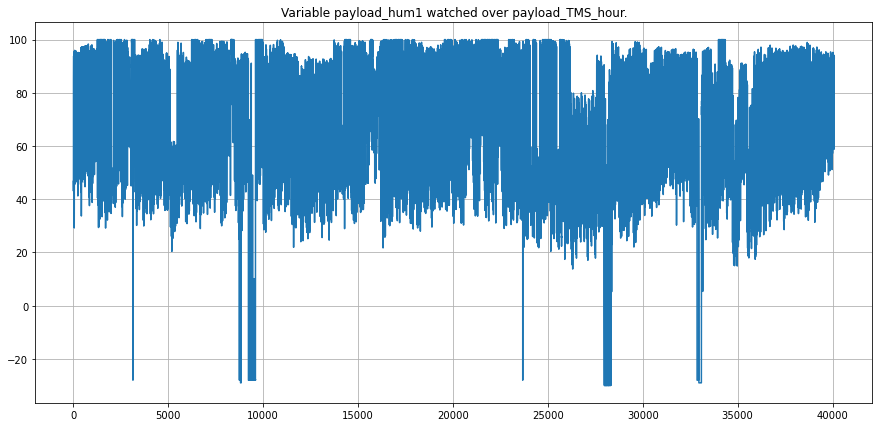

  payload_DID payload_TMS_date  payload_TMS_hour  payload_hum1  payload_prec  \
0        14_3       2021-02-16                18     46.700000           NaN   
1        14_3       2021-02-17                13     57.025000           NaN   
2        14_3       2021-02-17                14     50.975000           NaN   
3        14_3       2021-02-17                15     48.083333           NaN   
4        14_3       2021-02-17                16     43.087500           NaN   

   payload_solr  payload_tem1  
0    508.000000       26.6000  
1    293.250000       21.6000  
2    370.250000       24.2250  
3    459.833333       25.2000  
4    510.875000       27.2375  


In [35]:
PlotIndexSet(df=aux, x_axis='payload_TMS', y_axis='payload_hum1')

In [20]:
m = aux['payload_TMS'][0]
n = aux['payload_TMS'][1]
print(m.date())
print(m.time().hour)
print(type(m.time()))
m


if m.date() == n.date() and m.time().hour == n.time().hour:
    print("Espe eres la más bb")
else:
    print("Lucky-paila-game-over-3-2-1")


2000-01-01
0
<class 'datetime.time'>
Espe eres la más bb


In [21]:
au = aux.loc

In [ ]:
aux.head()

## Variables
    (RH)   -    Relative humidity 
    (T)    -    Temperature
    (OT)   -    Optimal temperature

# Conditions


### for germination

RH > 60%
15.5C < T   < 30C
18C   < OT  < 30C
RH + OT = high risk when sporulation - thus allows growers to spray fungicide at the optimal time to prevent primary infection. 



In [ ]:
df["payload.DID"].unique()
len(df["_id"].unique())